### VanHackathon 2019 : Prediction of best candidates for available jobs

#### Author: Anish Joni Jesudhas

#### Date: November 20th, 2019

### 1. Import Required Libraries 

In [120]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
import re
import textdistance
from tqdm import tqdm
tqdm.pandas()

# Configuring notebook env
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.expand_frame_repr', False)

F:\Learning\Anaconda3\envs\py37\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,userid,hiredforjobid,userskills,usersposition,jobid,jobresponsibilities,jobskills,jobsposition,hired
0,533441,1357,"django, docker, typescript, flask, numpy, pand...",Senior Developer / CTO,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,"javascript, ruby on rails",Lead BackEnd RoR Developer,1
1,696183,1357,"ruby on rails, javascript, python, java, html,...",Software Engineer,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,"javascript, ruby on rails",Lead BackEnd RoR Developer,1
2,696873,1357,"c++, erlang, linux kernel, tcp/ip, web develop...",Senior Software Engineer,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,"javascript, ruby on rails",Lead BackEnd RoR Developer,1
3,634908,1265,"oop, nosql, agile, agile development methodolo...",Full Stack Developer,1265,<p><strong>The ideal candidate:</strong><br>\n...,"agile, aws, continuous integration, java, java...",Senior Full Stack Developer,1
4,635261,1590,"fast learning, strong communication skills, gi...",Mobile Developer,1590,<ul>\n <li>4+ years experience in a related f...,"angular, cloud computing, javascript, kubernet...",Senior Software Developer,1


### 2. Prepare dataset for training model

In [121]:
# Prepare Positive Set
df_users = pd.read_csv(r'D:\vanhack\data\HiredCandidates.csv').reset_index(drop=True)
df_users = df_users.rename(columns={'Skills':'UserSkills'})

df_jobs = pd.read_csv(r'D:\vanhack\data\HiredJobDetails.csv').reset_index(drop=True)
df_jobs = df_jobs.rename(columns={'POSITION':'JobsPosition','Skills':'JobSkills','Responsibilities':'JobResponsibilities'})

cols_to_use = df_jobs.columns.difference(df_users.columns)

df = pd.merge(df_users,df_jobs[cols_to_use],left_on=['HiredForJobId'],right_on=['JobId'],how='inner')
df['hired'] = 1

df.columns = df.columns.str.lower()
df.head()

# Prepare Negative Set - Simple random selection

df_available = pd.read_csv(r'D:\vanhack\data\AvailableCandidates.csv')
df_available['hired'] = 0
df_available = df_available.sample(n=df.shape[0],random_state=2).reset_index(drop=True)
df_available = df_available.rename(columns={'Skills':'UserSkills'})
df_available.columns = df_available.columns.str.lower()
df_available = df_available[['userid','userskills','usersposition','hired']]
df_available = df_available.reset_index(drop=True)

df_jobs = df[['jobid','jobresponsibilities','jobsposition','jobskills']].reset_index(drop=True)
df_jobs.columns = df_jobs.columns.str.lower()

df_neg = pd.concat([df_available,df_jobs],axis=1)

df = df[df_neg.columns.values]
df = pd.concat([df,df_neg])

In [122]:
# complete set
print(df.shape)
df.head()

(404, 8)


,userid,userskills,usersposition,hired,jobid,jobresponsibilities,jobsposition,jobskills
0,533441,"django, docker, typescript, flask, numpy, pand...",Senior Developer / CTO,1,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,Lead BackEnd RoR Developer,"javascript, ruby on rails"
1,696183,"ruby on rails, javascript, python, java, html,...",Software Engineer,1,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,Lead BackEnd RoR Developer,"javascript, ruby on rails"
2,696873,"c++, erlang, linux kernel, tcp/ip, web develop...",Senior Software Engineer,1,1357,<p><br>\n</p>\n<p><strong>SEE THE FULL JOB DES...,Lead BackEnd RoR Developer,"javascript, ruby on rails"
3,634908,"oop, nosql, agile, agile development methodolo...",Full Stack Developer,1,1265,<p><strong>The ideal candidate:</strong><br>\n...,Senior Full Stack Developer,"agile, aws, continuous integration, java, java..."
4,635261,"fast learning, strong communication skills, gi...",Mobile Developer,1,1590,<ul>\n <li>4+ years experience in a related f...,Senior Software Developer,"angular, cloud computing, javascript, kubernet..."


### 3. Feature Engineering


In [123]:
# Engineer Features

def create_features(row):
    
#     def cleanhtml(raw_html):
#         cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
#         cleantext = re.sub(cleanr, '', raw_html)
#         return cleantext

    user_skills = str(row['userskills']).split(',')
    job_skills = str(row['jobskills']).split(',')
    #resp_skills = str(row['jobresponsibilities']).split(' ')

    user_skills = [x.strip(' ') for x in user_skills]
    job_skills = [x.strip(' ') for x in job_skills]

    # Responblities features were not usable
    #resp_skills = cleanhtml(resp_skills).split(' ')
    #filtered_words = [word for word in resp_skills if word not in stopwords.words('english')]
    #best_match = process.extractOne(search_name, np.delete(all_values,idx) ,scorer=fuzz.token_sort_ratio)

    common_skills = []
    #common_resp_skills = []
    other_skills = []

    for skill in user_skills:
        skill = skill.strip()
        if skill in job_skills:
            common_skills.append(skill)
        else:
            other_skills.append(skill)
            
#         if skill in resp_skills:
#             common_resp_skills.append(skill)        
            
    row['userskills_no'] = len(user_skills)
    row['jobskills_no'] = len(job_skills)
    row['common_skills_no'] = len(common_skills)
    row['common_skills_text'] = common_skills
   # row['common_resp_skills'] = common_resp_skills


    row['common_skills_ratio'] = (len(common_skills)/len(job_skills)) # 1 is ideal
    row['other_skills_ratio'] = (len(other_skills)/len(user_skills)) # 0 is ideal
    row['job_candiate_skill_ratio'] = (len(job_skills)/len(user_skills)) # 1 is ideal
    row['position_match'] = textdistance.cosine(str(row['usersposition']).lower(), str(row['jobsposition']).lower())  
          
    return row


df = df.apply(create_features,axis=1)
#df = df.sort_values(by='position_match',ascending=False)

In [139]:
# Viz engineered features

plot_cols = df.columns.difference(['userid','userskills','usersposition','hired',
                                   'common_skills_text','common_resp_skills','jobid','jobresponsibilities','jobsposition','jobskills'])
plot_cols = []

for idx,col in enumerate(plot_cols):
    print(col)
    df_hired = df[df['hired'] == 1]
    print(df_hired.shape)
    df_hired[col].plot.hist()
    plt.show()
    
    df_nothired = df[df['hired'] == 0]
    df_nothired[col].plot.hist()
    plt.show()

### 4. Train ML Models

Modeling binary classification with columns ['common_skills_ratio', 'other_skills_ratio', 'position_match', 'hired']
Training with 402 and testing with 2


F:\Learning\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 1
[3]	valid_0's auc: 1
[4]	valid_0's auc: 1
[5]	valid_0's auc: 1
[6]	valid_0's auc: 1
[7]	valid_0's auc: 1
[8]	valid_0's auc: 1
[9]	valid_0's auc: 1
[10]	valid_0's auc: 1
[11]	valid_0's auc: 1
[12]	valid_0's auc: 1
[13]	valid_0's auc: 1
[14]	valid_0's auc: 1
[15]	valid_0's auc: 1
[16]	valid_0's auc: 1
[17]	valid_0's auc: 1
[18]	valid_0's auc: 1
[19]	valid_0's auc: 1
[20]	valid_0's auc: 1
[21]	valid_0's auc: 1
[22]	valid_0's auc: 1
[23]	valid_0's auc: 1
[24]	valid_0's auc: 1
[25]	valid_0's auc: 1
[26]	valid_0's auc: 1
[27]	valid_0's auc: 1
[28]	valid_0's auc: 1
[29]	valid_0's auc: 1
[30]	valid_0's auc: 1
[31]	valid_0's auc: 1
[32]	valid_0's auc: 1
[33]	valid_0's auc: 1
[34]	valid_0's auc: 1
[35]	valid_0's auc: 1
[36]	valid_0's auc: 1
[37]	valid_0's auc: 1
[38]	valid_0's auc: 1
[39]	valid_0's auc: 1
[40]	valid_0's auc: 1
[41]	valid_0's auc: 1
[42]	valid_0's auc: 1
[43]	valid_0's auc: 1
[

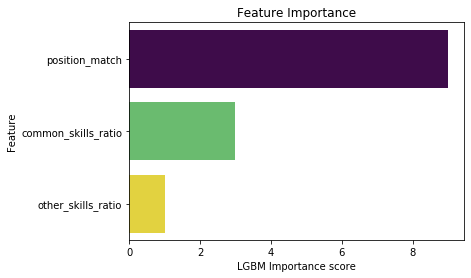

In [125]:
# Model a simple binary classification to find the optimum weights and select features

isDebug = False

features = ['common_skills_ratio','other_skills_ratio','position_match','hired']

df[features] = preprocessing.MinMaxScaler().fit_transform(df[features])

print('Modeling binary classification with columns', features)

df_model = df.copy()
df_model = df_model[features]

y = pd.DataFrame(df_model['hired'])
X = df_model.loc[:, df_model.columns != 'hired']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 if isDebug else 0.0049, random_state=42)

print('Training with {} and testing with {}'.format(X_train.shape[0],X_test.shape[0]))
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test)
    
np.random.seed(0)
nrounds = 100
params = {
    'objective': 'xentropy',
    'metric': "auc",
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'early_stopping_rounds': 100,
    'verbose': -1
}
gbm = lgb.train(params, train_dataset,valid_sets=[test_dataset], num_boost_round=nrounds)


def plot_imp(model, X):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)),columns=['score','feature'])
    feature_imp = feature_imp.sort_values(by='score',ascending=False)
    
    print(feature_imp)

    # Plot Feature Importance from trained model
    sns.set_color_codes("pastel")
    sns.barplot(x="score", y="feature",data=feature_imp.head(50),palette=mpl.cm.ScalarMappable(cmap='viridis_r').to_rgba((feature_imp["score"])))
    plt.xlabel("LGBM Importance score")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    return feature_imp

plot_imp(gbm,X)
plt.show()

### 5. Prepare Test Data for Prediction

In [127]:
# Create a superset with all jobs available and all candidates available
full_df=[]
for i in range(len(df_available)):
    for j in range(len(df_jobs)):
        user_id = df_available['userid'][i]
        user_position = df_available['usersposition'][i]
        user_skills  = df_available['userskills'][i]
        job_id = df_jobs['jobid'][j]
        job_position = df_jobs['jobsposition'][j]
        job_skills = df_jobs['jobskills'][j]
        full_df.append({'userid': user_id, 'userskills': user_skills, 'usersposition': user_position, 'jobid': job_id, 'jobsposition': job_position, 'jobskills': job_skills })
full_df = pd.DataFrame(full_df)

In [128]:
# Weights from Feature Importance
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)),columns=['score','feature'])
feature_imp.sort_values('score', ascending = False).reset_index(drop = True, inplace= True) 

#df = full_df.progress_apply(create_features,axis=1)
#df.to_csv('df.csv')
df = pd.read_csv('df.csv')

features = [ 'userskills_no','common_skills_ratio','other_skills_ratio','job_candiate_skill_ratio','position_match']
df[features] = preprocessing.MinMaxScaler().fit_transform(df[features])

df['match_score'] =  feature_imp['score'][2]*df['position_match'] + feature_imp['score'][1]*df['common_skills_ratio'] + df['other_skills_ratio']

df['match_score'] = df['match_score'] * 10

df = df.sort_values(by='match_score',ascending=False)

### 6. Results

In [130]:
# Filtering to only top 10 candidates by match score for each job
result = pd.DataFrame(df.groupby('jobid').head(10)).reset_index()
result.drop('index', axis = 1, inplace=True)
result.sort_values('jobsposition', axis = 0, inplace=True)

# Filtering to only essential features in result
essential_features = ['jobid', 'jobsposition', 'jobskills', 'usersposition', 'jobskills_no', 'common_skills_no', 'match_score', 'userskills', 'userid']
result = result[essential_features]
result.to_csv('result.csv')

In [132]:
result.head()

,jobid,jobsposition,jobskills,usersposition,jobskills_no,common_skills_no,match_score,userskills,userid
29,3030,Backend Developer,"api, aws, google cloud, java, mongodb, node.js...",Backend developer.,7,4,108.582291,"javascript, spring, jsf, hibernate, jpa, soap,...",603919
28,3030,Backend Developer,"api, aws, google cloud, java, mongodb, node.js...",Backend Developer,7,3,108.608374,"android, ruby on rails, javascript, python, c,...",637896
17,3030,Backend Developer,"api, aws, google cloud, java, mongodb, node.js...",Backend Developer,7,4,111.926910,"android, tdd, scrum, javascript, python, testi...",642839
26,3030,Backend Developer,"api, aws, google cloud, java, mongodb, node.js...",Back end Developer,7,4,108.892850,"javascript, spring, web development, node.js, ...",645329
25,3030,Backend Developer,"api, aws, google cloud, java, mongodb, node.js...",back-end developer,7,4,108.892850,"sql server, scrum, javascript, spring, html5, ...",645867


### Data Visualizations

In [134]:
# Data loading
HiredCandidates_df = pd.read_csv(r'D:\vanhack\data\HiredCandidates.csv')
HiredJobs_df = pd.read_csv(r'D:\vanhack\data\HiredJobDetails.csv')

Candidates_df = pd.read_csv(r'D:\vanhack\data\AvailableCandidates.csv')
JobsToPredict_df = pd.read_csv(r'D:\vanhack\data\JobsToPredict.csv')

In [135]:
# Candidates to be hired by position
CandidatesByPosition_df = Candidates_df.groupby(['UsersPosition']).size().to_frame('Candidate_count').reset_index()
CandidatesByPosition_df = CandidatesByPosition_df.sort_values('Candidate_count', ascending = False).head(10)

# Hired Candidates by position
HiredCandidatesByPosition_df = HiredCandidates_df.groupby(['UsersPosition']).size().to_frame('Candidate_count').reset_index()
HiredCandidatesByPosition_df = HiredCandidatesByPosition_df.sort_values('Candidate_count', ascending = False).head(10)

# Hired Jobs
HiredJobsPosition_df = HiredJobs_df.groupby(['POSITION']).size().to_frame('Jobs_count').reset_index()
HiredJobsPosition_df = HiredJobsPosition_df.sort_values('Jobs_count', ascending = False).head(10)

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Available Candidates count'),
 Text(0.5, 1.0, '#Candidates available to hire by Positions')]

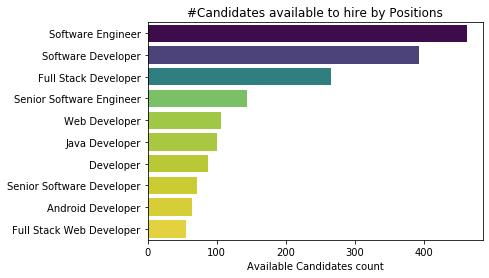

In [136]:
# Plot Talent pool by positions
sns.set_color_codes("pastel")
ax = sns.barplot(x="Candidate_count", y="UsersPosition", data=CandidatesByPosition_df,
           palette=plt.cm.ScalarMappable(cmap='viridis_r').to_rgba(CandidatesByPosition_df["Candidate_count"]))

ax.set(xlabel='Available Candidates count', ylabel='', title = '#Candidates available to hire by Positions')

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Hired Candidates count'),
 Text(0.5, 1.0, '#Candidates hired in each Position')]

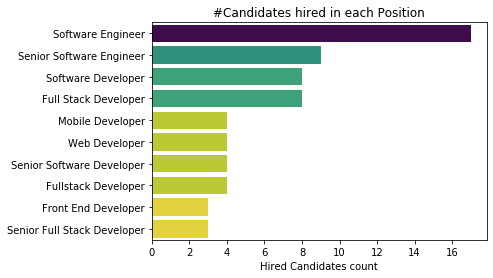

In [137]:
# Plot hired candidates by positions
sns.set_color_codes("pastel")
ax = sns.barplot(x="Candidate_count", y="UsersPosition", data=HiredCandidatesByPosition_df,
            palette=plt.cm.ScalarMappable(cmap='viridis_r').to_rgba(HiredCandidatesByPosition_df["Candidate_count"]))
ax.set(xlabel='Hired Candidates count', ylabel='', title = '#Candidates hired in each Position')

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Jobs Hired for(count)'),
 Text(0.5, 1.0, '#Jobs hired in each Position')]

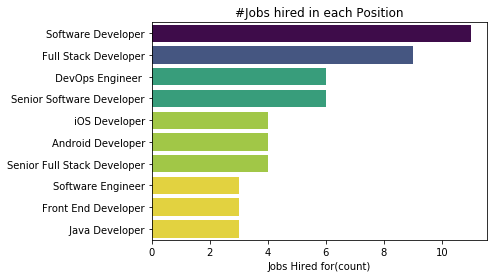

In [138]:
# Plot jobs hired by positions
sns.set_color_codes("pastel")
ax = sns.barplot(x="Jobs_count", y="POSITION", data=HiredJobsPosition_df,
            palette=plt.cm.ScalarMappable(cmap='viridis_r').to_rgba(HiredJobsPosition_df["Jobs_count"]))
ax.set(xlabel='Jobs Hired for(count)', ylabel='', title = '#Jobs hired in each Position')